# AVIOS — Workload Analysis: CPU-Bound Tasks

This notebook benchmarks AI-augmented Linux-like baseline scheduler vs the Linux-like baseline scheduler on a **CPU-heavy workload**.  
Goal: evaluate if AVIOS reduces turnaround and waiting time for **compute-intensive tasks** without harming fairness or interactivity.



**Results Summary —**

On a CPU-intensive workload with 942 tasks, the AI-augmented Linux-like scheduler achieved a clear improvement over the baseline:

•	**Average Turnaround Time reduced by 17.9% (from 11,044 → 9,069 ticks).**

•	**Average Response Time reduced by 17.9% (from 11,002 → 9,027 ticks).**

•	**Median Turnaround Time also showed a slight gain (0.8% lower).**

•	**Fairness, CPU utilization, and throughput remained identical, confirming no trade-off in overall system balance.**

•	**Context switches dropped slightly (~0.3%), showing reduced scheduling overhead.**

 **Interpretation:** For compute-heavy tasks, AVIOS significantly improves responsiveness and completion times without compromising fairness or efficiency, demonstrating its ability to allocate CPU cycles more intelligently than the baseline.


In [59]:
# ================================
# PART 1: Load Models + Dataset
# ================================
import pandas as pd
import joblib
import json
import numpy as np

# ----------------------------------
# 1. Load models + encoders
# ----------------------------------
rf_resource_model = joblib.load("resource_model_rf.pkl")
le_resource = joblib.load("le_resource_model.pkl")

xgb_inter_model = joblib.load("interactivity_model_xgb.pkl")
le_inter = joblib.load("le_interactivity_model.pkl")

rf_priority_model = joblib.load("priority_model_rf.pkl")
le_priority = joblib.load("le_priority_model.pkl")

rf_execution_model = joblib.load("execution_model_rf.pkl")
le_execution = joblib.load("le_execution_model.pkl")

print("✅ Models + LabelEncoders loaded.")

# ----------------------------------
# 2. Load feature lists
# ----------------------------------
resource_feats      = json.load(open("resource_features.json"))
interactivity_feats = json.load(open("interactivity_features.json"))
priority_feats      = json.load(open("priority_features.json"))
execution_feats     = json.load(open("execution_features.json"))
print(resource_feats)
print(interactivity_feats)
print(priority_feats)
print(execution_feats)

print("✅ Feature sets loaded.")

# ----------------------------------
# 3. Load dataset
# ----------------------------------
df = pd.read_csv("cpu_workload.csv")

# Ensure timestamps are datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.sort_values(by="Timestamp")

print(f"📊 Original dataset shape: {df.shape}")

# ----------------------------------
# 4. Keep only first occurrence of each PID
# ----------------------------------
first_occ = df.drop_duplicates(subset=["PID"], keep="first").reset_index(drop=True)
print(f"📊 First occurrence dataset shape: {first_occ.shape}")

# ----------------------------------
# 5. Preprocessing (same as training)
# ----------------------------------
def preprocess_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """Clean + engineer features to match training pipeline."""

    # Convert VmRSS (kB → float)
    if 'VmRSS' in df.columns:
        df['VmRSS'] = (
            df['VmRSS']
            .astype(str)
            .str.replace('kB', '', regex=False)
            .astype(float)
            .fillna(0.0)
        )

    # Safe numeric conversion
    num_cols = [
        'CPU_Usage_%','Nice','Priority','Total_Time_Ticks',
        'Elapsed_Time_sec','Voluntary_ctxt_switches','Nonvoluntary_ctxt_switches',
        'IO_Read_Bytes','IO_Write_Bytes','IO_Read_Count','IO_Write_Count',
        'se.sum_exec_runtime','se.load.weight'
    ]
    for col in num_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    # Avoid divide by zero
    df['Elapsed_Time_sec'] = df['Elapsed_Time_sec'].replace(0, 1e-5)

    # Engineered features
    df['avg_cpu_time'] = df['Total_Time_Ticks'] / df['Elapsed_Time_sec']
    df['cpu_to_elapsed_ratio'] = df['CPU_Usage_%'] / df['Elapsed_Time_sec']
    df['interactivity_score'] = (
        df['Voluntary_ctxt_switches'] / (df['Nonvoluntary_ctxt_switches'] + 1)
    )
    df['is_sleeping'] = (
        df['State'].astype(str).str.lower().str.contains('sleeping', na=False).astype(int)
    )

    return df

# Apply preprocessing
first_occ = preprocess_dataset(first_occ)
first_occ['Arrival_Sec'] = ((first_occ['Timestamp'] - first_occ['Timestamp'].iloc[0]).dt.total_seconds().astype(int))

# ----------------------------------
# 6. Save for AI scheduler input
# ----------------------------------
first_occ.to_csv("ai_scheduler_input.csv", index=False)
print("✅ Saved ai_scheduler_input.csv (clean + preprocessed)")


✅ Models + LabelEncoders loaded.
['CPU_Usage_%', 'Threads', 'Voluntary_ctxt_switches', 'Nonvoluntary_ctxt_switches', 'IO_Read_Bytes', 'IO_Write_Bytes', 'IO_Read_Count', 'IO_Write_Count', 'se.sum_exec_runtime']
['Scheduling_Policy', 'Nice', 'CPU_Usage_%', 'Total_Time_Ticks', 'Voluntary_ctxt_switches', 'Nonvoluntary_ctxt_switches', 'Elapsed_Time_sec', 'State', 'interactivity_score', 'is_sleeping']
['Priority', 'Nice', 'se.load.weight', 'Threads']
['Total_Time_Ticks', 'Elapsed_Time_sec', 'se.sum_exec_runtime', 'avg_cpu_time']
✅ Feature sets loaded.
📊 Original dataset shape: (187728, 28)
📊 First occurrence dataset shape: (942, 28)
✅ Saved ai_scheduler_input.csv (clean + preprocessed)


In [60]:
# ================================
# PART 2: Task Class Definition
# ================================
import uuid
import numpy as np

class Task:
    """Represents a process/task in our AI Scheduler."""

    def __init__(self, row):
        # --- Original features (dict for ML models) ---
        if hasattr(row, "to_dict"):
            self.features = row.to_dict()
        elif isinstance(row, dict):
            self.features = dict(row)
        else:
            try:
                self.features = dict(row)
            except Exception:
                self.features = {}

        # --- Identity ---
        self.pid = self.features.get("PID")
        self.name = self.features.get("Name", f"T{self.pid}")

        # Prefer Linux CFS runtime if available, else fallback
        sum_exec = float(self.features.get("se.sum_exec_runtime", 0))
        total_ticks = float(self.features.get("Total_Time_Ticks", 0))

        # If Total_Time_Ticks is 0, fallback to sum_exec_runtime
        self.total_time = int(total_ticks if total_ticks > 0 else sum_exec)
        self.remaining = self.total_time
        self.arrival_time = int(self.features.get("Arrival_Sec", 0))

        # --- Classification labels (to be predicted later) ---
        self.resource_type = None
        self.interactivity = None
        self.priority_class = None
        self.execution_class = None

        # --- Scheduling assignments ---
        self.subqueue_score = None
        self.assigned_scheduler = None   # FIFO / RR / CFS / IDLE
        self.subqueue = None

        # --- Runtime execution info ---
        self.quantum = None
        self.total_run = 0
        self.first_start = None
        self.completion_time = None

        # --- CFS-specific ---
        self.vruntime = float(self.features.get("se.vruntime", 0))
        self.weight = float(self.features.get("se.load.weight", 1024))

        # --- Affinity ---
        self.last_core = None

        # --- Logging ID (optional, unique) ---
        self.uid = str(uuid.uuid4())[:8]


    @classmethod
    def from_row(cls, row):
        # Accept Series or dict
        if hasattr(row, "to_dict"):
            return cls(row)
        else:
            return cls(row)

    def get_feature_vector(self, category: str):
        """Return numpy array [1, n_features] in the right order."""
        if category == "resource":
            feats_list = {f: self.features.get(f, 0) for f in resource_feats}
        elif category == "interactivity":
            feats_list = {f: self.features.get(f, 0) for f in interactivity_feats}
        elif category == "priority":
            feats_list = {f: self.features.get(f, 0) for f in priority_feats}
        elif category == "execution":
             feats_list = {f: self.features.get(f, 0) for f in execution_feats}
        else:
            raise ValueError(f"Unknown feature category: {category}")

        values = []
        for f in feats_list:
            val = self.features.get(f, 0)

            # Handle mappings
            if f == "Scheduling_Policy":
                mapping = {"SCHED_OTHER": 0, "SCHED_FIFO": 1, "SCHED_RR": 2, "SCHED_IDLE": 3}
                val_upper = str(val).upper() if val is not None else ""
                val = mapping.get(val_upper, 0)
            elif f == "State":
                mapping = {"RUNNING": 0, "SLEEPING": 1, "STOPPED": 2, "ZOMBIE": 3}
                val_upper = str(val).upper() if val is not None else ""
                val = mapping.get(val_upper, 0)
            else:
                try:
                    val = float(val)
                except Exception:
                    val = 0.0

            values.append(val)

        return np.array([values])  # keep 2D shape for sklearn

    def to_log_dict(self, current_time=None, state="READY"):
        """Return dict snapshot for logging."""
        return {
            "timestamp": current_time,
            "pid": self.pid,
            "name": self.name,
            "arrival_time": self.arrival_time,
            "assigned_scheduler": self.assigned_scheduler,
            "subqueue": self.subqueue,
            "labels": {
                "resource": self.resource_type,
                "interactivity": self.interactivity,
                "priority": self.priority_class,
                "execution": self.execution_class,
            },
            "subqueue_score": self.subqueue_score,
            "quantum": self.quantum,
            "remaining": self.remaining,
            "total_run": self.total_run,
            "first_start": self.first_start,
            "completion_time": self.completion_time,
            "vruntime": self.vruntime,
            "weight": self.weight,
            "last_core": self.last_core,
            "state": state
        }

    def __repr__(self):
        return (f"<Task pid={self.pid} name={self.name} "
                f"arr={self.arrival_time} sched={self.assigned_scheduler} "
                f"subq={self.subqueue} remaining={self.remaining}>")


In [61]:
# ------------------------------
# AI Augmented LinuxBaseline Scheduler
# ------------------------------
import heapq
import itertools
from collections import deque, defaultdict
import pandas as pd
import numpy as np
import time

class AIScheduler:

    def __init__(self, num_cores=4, core_priority_order=None,
                 rr_quantum=100, cfs_base_slice=4, seed=42, models=None, encoders=None):
        self.num_cores = num_cores
        self.rr_quantum = int(rr_quantum)
        self.cfs_base_slice = float(cfs_base_slice)  # used as base multiplier
        self.insertion_counter = itertools.count()
        self.seed = seed

        # -----------------------------
        # ML Models + Encoders
        # -----------------------------
        self.models = models if models else {}
        self.encoders = encoders if encoders else {}

        if models:
           self.models = models
        else:
           self.models = {
               "resource": rf_resource_model,
               "interactivity": xgb_inter_model,
               "priority": rf_priority_model,
               "execution": rf_execution_model
           }

        if encoders:
           self.encoders = encoders
        else:
           self.encoders = {
              "resource": le_resource,
              "interactivity": le_inter,
              "priority": le_priority,
              "execution": le_execution
           }

        self.feature_lists = {
            "resource": json.load(open("resource_features.json")),
            "interactivity": json.load(open("interactivity_features.json")),
            "priority": json.load(open("priority_features.json")),
            "execution": json.load(open("execution_features.json"))
        }

        # per-core priority order
        self.core_priority_order = core_priority_order or {
            cid: ["FIFO", "RR", "CFS", "IDLE"] for cid in range(num_cores)
        }

        self.queues = {
            "FIFO": {"fifo_1": deque()},
            "RR": {"rr_1": deque()},
            "CFS": {"cfs_1": [] },   # min-heaps of (vruntime, counter, pid, task)
            "IDLE": {"idle": deque()}
        }

        # cores state: dict per core: {"task": Task or None, "time_left": int quantum remaining}
        self.cores = {cid: {"task": None, "time_left": 0} for cid in range(num_cores)}

        # runtime bookkeeping
        self.time = 0
        self.logs = []            # list of event dicts
        self.task_map = {}        # pid -> Task
        self.completed_tasks = {}
        self.context_switches = 0

        # small constants to approximate Linux behavior
        self.NICE0_WEIGHT = 1024.0  # used for vruntime update
        self.min_granularity = 1    # minimum quantum tick granularity (1 tick)

    # --------------------
    # Utilities / helpers
    # --------------------
    def _log(self, event_type, task=None, core=None, extra=None):
        row = {
            "time": self.time,
            "event": event_type,
            "core": core,
            "pid": getattr(task, "pid", None),
            "name": getattr(task, "name", None),
        }
        if task is not None:
            row.update({
                "assigned_scheduler": task.assigned_scheduler,
                "subqueue": task.subqueue,
                "remaining": task.remaining,
                "quantum": task.quantum,
                "vruntime": getattr(task, "vruntime", None),
                "subqueue_score": getattr(task, "subqueue_score", None),
            })
        if extra:
            row.update(extra)
        self.logs.append(row)

    def all_queues_empty(self):
        # check both queue structures and running cores
        for sched in self.queues:
            for subq in self.queues[sched]:
                if len(self.queues[sched][subq]) > 0:
                    return False
        for cid in self.cores:
            if self.cores[cid]["task"] is not None:
                return False
        return True

    # --------------------
    # Enqueue / Dequeue
    # --------------------
    def _cfs_insert(self, subq, task):
        # push (vruntime, counter, pid, task)
        entry = (float(task.vruntime), next(self.insertion_counter), task.pid, task)
        heapq.heappush(self.queues["CFS"][subq], entry)

    def _cfs_pop_min(self, subq):
        heap = self.queues["CFS"][subq]
        while heap:
            vr, _, pid, task = heapq.heappop(heap)
            if abs(float(task.vruntime) - float(vr)) < 1e-6:
                return task
            else:
                # stale entry: push a fresh one and continue popping next
                entry = (float(task.vruntime), next(self.insertion_counter), task.pid, task)
                heapq.heappush(heap, entry)
                # continue popping - eventual correct entry will match
        return None

    def _enqueue_task(self, task):
        """Place task into the queue structure according to assigned_scheduler/subqueue."""
        sched = task.assigned_scheduler or "CFS"
        subq = task.subqueue or (list(self.queues[sched].keys())[0])
        if sched == "CFS":
            self._cfs_insert(subq, task)
        else:
            self.queues[sched][subq].append(task)
        self._log("ENQUEUE", task)

    def _dequeue_task(self, sched, subq):
        if sched == "CFS":
            return self._cfs_pop_min(subq)
        else:
            q = self.queues[sched][subq]
            return q.popleft() if q else None

    # --------------------
    # Admission
    # --------------------
    def admit(self, task, current_time=None):
        """
        AI-aware admit:
         - run ML classification + scoring (preserved exactly),
         - estimate remaining,
         - assign scheduler/subqueue (kept as your mapping),
         - set vruntime/weight from features if available,
         - set RR initial quantum if needed,
         - enqueue and log (Linux-style).
        """
        if current_time is None:
            current_time = self.time

        # Ensure arrival_time present
        if getattr(task, "arrival_time", None) is None:
            task.arrival_time = int(current_time)

        # Register in task_map
        self.task_map[task.pid] = task

        # ---- AI classification + scoring (preserve your logic) ----
        # This may set: resource_type, interactivity, priority_class, execution_class
        self._classify_task(task)

        # numeric labels (returns tuple) — calling for completeness (you keep original logic)
        try:
            self._map_numeric_labels(task.resource_type, task.interactivity, task.execution_class, task.priority_class)
        except Exception:
            pass

        # compute combined subqueue score (sets task.subqueue_score)
        try:
            self._compute_subqueue_score(task)
        except Exception:
            pass

        # Estimate remaining if not already present (keep conservative fallback)
        if getattr(task, "remaining", None) is None or task.remaining == 0:
            # prefer Total_Time_Ticks feature, else fallback to task.total_time or 1
            task.remaining = int(task.features.get("Total_Time_Ticks", getattr(task, "total_time", 1) or 1))

        # ---- Assign scheduler/subqueue (your mapping kept) ----
        # NOTE: preserve explicit scheduling policy for SCHED_RR too (Linux-like)
        sched_pol = str(task.features.get("Scheduling_Policy", "")).upper()
        if sched_pol == "SCHED_FIFO":
            task.assigned_scheduler = "FIFO"
            task.subqueue = "fifo_1"
        elif sched_pol == "SCHED_RR":
            task.assigned_scheduler = "RR"
            task.subqueue = "rr_1"
        elif sched_pol == "SCHED_IDLE":
            task.assigned_scheduler = "IDLE"
            task.subqueue = "idle"
        else:
            # task.assigned_scheduler = "CFS"
            # task.subqueue = "cfs_1"
            self._assign_scheduler_and_subqueue(task)

        # ---- Ensure vruntime and weight (from features when available) ----
        task.vruntime = float(task.features.get("se.vruntime", getattr(task, "vruntime", 0.0) or 0.0))
        task.weight = float(task.features.get("se.load.weight", getattr(task, "weight", 1024.0) or 1024.0))

        # ---- For RR, set an initial quantum (Linux-like) ----
        if getattr(task, "assigned_scheduler", None) == "RR":
            # task.quantum = max(self.min_granularity, int(getattr(self, "rr_quantum", 5)))
            base_score = 2.5
            max_score = 3.15
            base_quantum = 100
            max_quantum = 200
            score = float(getattr(task, "subqueue_score", 2.0))
            if score <= base_score:
                 task.quantum = base_quantum
            elif score >= max_score:
                task.quantum = max_quantum
            else:
               # Linear growth between base_score and max_score
                frac = (score - base_score) / (max_score - base_score)
                task.quantum = int(base_quantum + frac * (max_quantum - base_quantum))
        else:
            # leave quantum to be computed at dispatch for CFS/FIFO (or None)
            task.quantum = getattr(task, "quantum", None)

        # final enqueue + log (use existing logging helper)
        try:
            self._log("ADMIT", task)
        except Exception:
            # fallback to appending a simple log row if _log is not available
            self.logs.append({"time": current_time, "event": "ADMIT", "pid": getattr(task, "pid", None)})

        self._enqueue_task(task)

    # --------------------
    # AI helpers
    # --------------------

    def _classify_task(self, task):
        """
        Run ML models to classify task into 4 categories.
        Kept identical to your implementation (safe fallbacks included).
        """
        try:
           # Resource
           X_res = task.get_feature_vector("resource")
           X_res = pd.DataFrame(X_res, columns=self.feature_lists["resource"])
           pred_res = self.models["resource"].predict(X_res)[0]
           try:
              task.resource_type = self.encoders["resource"].inverse_transform([pred_res])[0]
           except Exception:
              task.resource_type = "Mixed"  # fallback safe default

           # Interactivity
           X_int = task.get_feature_vector("interactivity")
           X_int = pd.DataFrame(X_int, columns=self.feature_lists["interactivity"])
           pred_int = self.models["interactivity"].predict(X_int)[0]
           try:
              task.interactivity = self.encoders["interactivity"].inverse_transform([pred_int])[0]
           except Exception:
              task.interactivity = "Other"

           # Priority
           X_pri = task.get_feature_vector("priority")
           X_pri = pd.DataFrame(X_pri, columns=self.feature_lists["priority"])
           pred_pri = self.models["priority"].predict(X_pri)[0]
           try:
              task.priority_class = self.encoders["priority"].inverse_transform([pred_pri])[0]
           except Exception:
              task.priority_class = "Medium"

           # Execution
           X_exe = task.get_feature_vector("execution")
           X_exe = pd.DataFrame(X_exe, columns=self.feature_lists["execution"])
           pred_exe = self.models["execution"].predict(X_exe)[0]
           try:
              task.execution_class = self.encoders["execution"].inverse_transform([pred_exe])[0]
           except Exception:
              task.execution_class = "Medium"

        except Exception as e:
               print(f"⚠️ Classification failed for PID={getattr(task,'pid',None)}: {e}")
               task.resource_type = task.resource_type or "Mixed"
               task.interactivity = task.interactivity or "Other"
               task.priority_class = task.priority_class or "Medium"
               task.execution_class = task.execution_class or "Medium"

    def _map_numeric_labels(self, resource, inter, exec_c, priority):
        Rmap = {"CPU-bound": 3, "Mixed": 2, "IO-bound": 1}
        Imap = {"Real-time": 4, "Interactive": 3, "Other": 2, "Background": 1.5, "Batch": 1}
        Emap = {"Short": 3, "Medium": 2, "Long": 1}
        Pmap = {"High": 3, "Medium": 2, "Low": 1}
        return (
            Rmap.get(resource, 2),
            Imap.get(inter, 2),
            Emap.get(exec_c, 2),
            Pmap.get(priority, 2)
        )

    def _compute_subqueue_score(self, task):
        Rnum, Inum, Enum, Pnum = self._map_numeric_labels(
            task.resource_type, task.interactivity, task.execution_class, task.priority_class
        )
        w_r, w_i, w_e, w_p = 0.2, 0.35, 0.2, 0.3
        task.subqueue_score = float(w_r*Rnum + w_i*Inum + w_e*Enum + w_p*Pnum)
        return task.subqueue_score

    def _assign_scheduler_and_subqueue(self, task):
        # Strict policy overrides
        sched_pol = str(task.features.get("Scheduling_Policy", "")).upper()
        if sched_pol == "SCHED_FIFO":
            task.assigned_scheduler = "FIFO"; task.subqueue = "fifo_1"; return
        if sched_pol == "SCHED_IDLE":
            task.assigned_scheduler = "IDLE"; task.subqueue = "idle"; return

        score = float(getattr(task, "subqueue_score", 0.0))
        rt, inter, exec_t, prio = task.resource_type, task.interactivity, task.execution_class, task.priority_class

        if inter == "Real-time":
            task.assigned_scheduler = "FIFO"
            task.subqueue = "fifo_1"
            return

        elif (inter == "Interactive" and exec_t == "Short" and (prio in ["High"])) or score > 2.6:
            task.assigned_scheduler = "RR"
            task.subqueue = "rr_1"
            return

        else :
            task.assigned_scheduler = "CFS"
            task.subqueue = "cfs_1"
            return

    # --------------------
    # Core pick & dispatch
    # --------------------
    def _pick_task_for_core(self, core_id):
        """
        Linux-like: iterate per-core priority order, pick first non-empty subqueue.
        Returns (sched, subq) or (None, None).
        """
        order = self.core_priority_order.get(core_id, ["FIFO", "RR", "CFS", "IDLE"])
        for sched in order:
            # within a scheduler prefer higher subqueue keys in order (fifo_1 before fifo_2)
            subqueues = list(self.queues[sched].keys())
            for subq in subqueues:
                if len(self.queues[sched][subq]) == 0:
                    continue
                # for CFS peek min
                if sched == "CFS":
                    candidate = None
                    heap = self.queues["CFS"][subq]
                    # peek valid entry
                    if heap:
                        vr, _, pid, task = heap[0]
                        candidate = task
                else:
                    candidate = self.queues[sched][subq][0]
                if candidate is not None:
                    # pick first available per scheduler priority
                    return sched, subq
        return None, None

    def _dispatch_to_core(self, core_id, sched, subq):
        task = self._dequeue_task(sched, subq)
        if task is None:
            return None
        # initialize quantum for CFS using base slice formula if not RR/FIFO
        if sched == "CFS":
            runnable_set_weight = sum(
                 [t.weight if t.weight > 0 else self.NICE0_WEIGHT
                 for subq in self.queues["CFS"].values()
                  for _, _, _, t in subq]   # iterate over heap entries
            )
            if runnable_set_weight <= 0:
                   runnable_set_weight = task.weight or self.NICE0_WEIGHT
            sched_latency_ticks = 48  # you can tune (Linux default ~48ms window)
            proportion = (task.weight or self.NICE0_WEIGHT) / runnable_set_weight
            base_slice = int(sched_latency_ticks * proportion)

            # task.quantum = max(self.min_granularity, base_slice)
            score = float(getattr(task, "subqueue_score", 2.0))
            exec_class = getattr(task, "execution_class", "Medium")
            exec_factor_map = {"Short": 1.0, "Medium": 1.5, "Long": 2.0}
            exec_scale = exec_factor_map.get(exec_class, 1.5)
            score_scale = 1.0 + 0.2 * (score - 2.0)  # light bonus, e.g. +20% at high score
            quanta = base_slice * exec_scale * score_scale
            task.quantum = max(self.min_granularity, int(quanta))

        elif sched == "FIFO":
            # FIFO runs until completion (set quantum = remaining)
            task.quantum = max(1, int(task.remaining))
        elif sched == "RR":
            # task.quantum = max(self.min_granularity, int(self.rr_quantum))
            base_score = 2.5
            max_score = 3.15
            base_quantum = 100
            max_quantum = 200
            score = float(getattr(task, "subqueue_score", 2.0))
            if score <= base_score:
                 task.quantum = base_quantum
            elif score >= max_score:
                task.quantum = max_quantum
            else:
               # Linear growth between base_score and max_score
                frac = (score - base_score) / (max_score - base_score)
                task.quantum = int(base_quantum + frac * (max_quantum - base_quantum))

        else:
            task.quantum = max(1, int(task.remaining))

        # set running on core
        self.cores[core_id]["task"] = task
        self.cores[core_id]["time_left"] = int(task.quantum)
        if task.first_start is None:
            task.first_start = self.time
        self.context_switches += 1
        self._log("DISPATCH", task, core=core_id)
        return task

    # --------------------
    # Per-tick execution
    # --------------------
    def _update_vruntime(self, task, delta=1):
        # vruntime += delta * (NICE0_WEIGHT / weight)
        if task.weight <= 0:
            task.weight = 1.0
        # task.vruntime += float(delta) * (self.NICE0_WEIGHT / float(task.weight))
        base_inc = float(delta) * (self.NICE0_WEIGHT / float(task.weight))
        score = float(getattr(task, "subqueue_score", 2.0))
        score_scale = 2.0 / max(0.5, score)
        task.vruntime += base_inc * score_scale

    def _run_one_tick_on_core(self, core_id):
        core = self.cores[core_id]
        task = core["task"]
        if task is None:
            # idle; nothing to do
            return
        # run one tick
        task.remaining = max(0, int(task.remaining) - 1)
        task.total_run = getattr(task, "total_run", 0) + 1
        core["time_left"] = max(0, core["time_left"] - 1)

        # update vruntime only for CFS tasks
        if task.assigned_scheduler == "CFS":
            self._update_vruntime(task, delta=1)

        # log run
        self._log("RUN", task, core=core_id)

        # completion?
        if task.remaining <= 0:
            task.completion_time = self.time
            self.completed_tasks[task.pid] = task
            self._log("COMPLETE", task, core=core_id)
            # clear core
            core["task"] = None
            core["time_left"] = 0
            return

        # quantum expired?
        if core["time_left"] <= 0:
            # for RR → requeue to RR subqueue (round robin)
            if task.assigned_scheduler == "RR":
                self._log("PREEMPT", task, core=core_id, extra={"reason": "quantum_expired"})
                # requeue at end of its RR subqueue
                self.queues["RR"][task.subqueue].append(task)
                core["task"] = None
                core["time_left"] = 0
            elif task.assigned_scheduler == "CFS":
                # update vruntime already updated per tick; re-insert to heap
                self._log("PREEMPT", task, core=core_id, extra={"reason": "cfs_quantum_expired"})
                self._cfs_insert(task.subqueue, task)
                core["task"] = None
                core["time_left"] = 0
            elif task.assigned_scheduler == "FIFO":
                # FIFO shouldn't preempt on quantum expiry (we set quantum=remaining). But if it happens, requeue front.
                self._log("PREEMPT", task, core=core_id, extra={"reason": "fifo_preempt"})
                self.queues["FIFO"][task.subqueue].appendleft(task)
                core["task"] = None
                core["time_left"] = 0
            else:
                # IDLE or others
                core["task"] = None
                core["time_left"] = 0

    # --------------------
    # Main tick (called every simulated second/tick)
    # --------------------
    def tick(self, current_time=None):
        if current_time is None:
            current_time = self.time
        self.time = int(current_time)

        # for each core: if no running task try to pick one; else run one tick
        for cid in range(self.num_cores):
            if self.cores[cid]["task"] is None:
                sched, subq = self._pick_task_for_core(cid)
                if sched is not None:
                    self._dispatch_to_core(cid, sched, subq)
            # run one tick on the core (if any)
            self._run_one_tick_on_core(cid)

    # --------------------
    # Metrics & export
    # --------------------
    def export_logs(self):
        return pd.DataFrame(self.logs)

    def export_task_metrics(self):
        # build per-task metrics from completed_tasks + task_map
        rows = []
        for pid, task in self.task_map.items():
            if pid in self.completed_tasks:
                t = self.completed_tasks[pid]
                arrival = getattr(t, "arrival_time", None)
                first = getattr(t, "first_start", None)
                comp = getattr(t, "completion_time", None)
                exec_time = getattr(t, "total_run", 0)
                waiting = (first - arrival) if (first is not None and arrival is not None) else None
                turnaround = (comp - arrival) if (comp is not None and arrival is not None) else None
                response = waiting
                stretch = turnaround / exec_time if exec_time > 0 and turnaround is not None else None
                rows.append({
                    "pid": pid, "name": t.name,
                    "arrival": arrival, "first_start": first, "completion": comp,
                    "execution_time": exec_time, "waiting": waiting,
                    "turnaround": turnaround, "response": response, "stretch": stretch,
                    "scheduler": t.assigned_scheduler, "subqueue": t.subqueue
                })
        return pd.DataFrame(rows)

    def compute_aggregate_metrics(self):
        df = self.export_task_metrics()
        if df.empty:
            return {}
        metrics = {}
        metrics["avg_turnaround"] = df["turnaround"].mean()
        metrics["median_turnaround"] = df["turnaround"].median()
        metrics["avg_response"] = df["response"].mean()
        metrics["p95_response"] = df["response"].quantile(0.95)
        # Jain fairness on execution_time vs share (simple)
        execs = df["execution_time"].fillna(0).values
        metrics["fairness_index"] = (execs.sum()**2) / (len(execs) * (np.sum(execs**2) + 1e-9))
        # core utilization estimate: sum of runtime on cores / simulation length
        total_time = max(1, self.time)
        utiliz = {}
        for cid in range(self.num_cores):
            # approximate: count RUN events on core
            core_runs = sum(1 for r in self.logs if r["event"] == "RUN" and r["core"] == cid)
            utiliz[cid] = core_runs / total_time
        metrics["core_utilization"] = utiliz
        metrics["context_switches"] = self.context_switches
        total = len(self.task_map)
        completed = len(self.completed_tasks)
        metrics["tasks_total"] = total
        metrics["tasks_completed"] = completed
        print(f"✅ Simulation summary: {completed}/{total} tasks finished.")
        return metrics



In [62]:
# ================================
# SIMULATION DRIVER (AI Scheduler)
# ================================
import pandas as pd
import time
from collections import defaultdict

# --- Config ---
INPUT_CSV = "ai_scheduler_input.csv"
LOG_OUT   = "ai_scheduler_logs.csv"
TASK_MET  = "ai_scheduler_task_metrics.csv"
MAX_SIM_SECONDS_MULT = 5
PROGRESS_EVERY = 1000

# 1) Load dataset & prepare arrivals
df = pd.read_csv(INPUT_CSV)
if "Timestamp" in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

if 'Arrival_Sec' not in df.columns:
    if 'Timestamp' in df.columns and not df['Timestamp'].isnull().all():
        start_ts = df['Timestamp'].min()
        df['Arrival_Sec'] = ((df['Timestamp'] - start_ts).dt.total_seconds()
                             .fillna(0).astype(int))
    else:
        df['Arrival_Sec'] = 0

df = df.sort_values(by='Arrival_Sec').reset_index(drop=True)
last_arrival = int(df['Arrival_Sec'].max())
print(f"📊 Loaded dataset: {len(df)} tasks, last arrival @ {last_arrival}s")

# Build arrivals dict for fast lookup
arrivals = defaultdict(list)
for _, row in df.iterrows():
    arrivals[int(row['Arrival_Sec'])].append(row)

# 2) Initialize scheduler
scheduler = AIScheduler(num_cores=4)   # tune cores if needed
print("✅ AIScheduler initialized.")

# 3) Compute recommended max_ticks
if "Total_Time_Ticks" in df.columns:
    total_work = df["Total_Time_Ticks"].fillna(0).astype(float).sum()
elif "se.sum_exec_runtime" in df.columns:
    total_work = df["se.sum_exec_runtime"].fillna(0).astype(float).sum()
else:
    total_work = 0.0

num_cores = scheduler.num_cores if hasattr(scheduler, "num_cores") else 4

max_ticks = 1000000
print(f"Using max_ticks = {max_ticks} "
      f"(last_arrival={last_arrival}, total_work={total_work}, cores={num_cores})")

# 4) Run simulation loop
current_time = 0
start_time_wall = time.time()

while True:
    # Admit arrivals at this tick
    if current_time in arrivals:
        for row in arrivals[current_time]:
            t = Task.from_row(row)
            scheduler.admit(t, current_time)

    # Run one tick
    scheduler.tick(current_time)

    # Progress print
    if current_time % PROGRESS_EVERY == 0 and current_time > 0:
        print(f"⏱ tick {current_time} — queues empty? {scheduler.all_queues_empty()}")

    # Termination condition (stop only after all arrivals & queues empty)
    if current_time > last_arrival and scheduler.all_queues_empty():
        print("All tasks completed and no pending arrivals -> stopping.")
        break

    current_time += 1
    if current_time > max_ticks:
        print("⚠️ Reached safety max_ticks — stopping simulation to avoid runaway.")
        break

wall_elapsed = time.time() - start_time_wall
print(f"✅ Simulation finished in {wall_elapsed:.1f}s (simulated ticks: {current_time})")

# 5) Export logs & per-task metrics
logs_df = scheduler.export_logs()
logs_df.to_csv(LOG_OUT, index=False)
print(f"📑 Logs saved to {LOG_OUT} (rows: {len(logs_df)})")

task_metrics_df = scheduler.export_task_metrics()
task_metrics_df.to_csv(TASK_MET, index=False)
print(f"📊 Per-task metrics saved to {TASK_MET} (rows: {len(task_metrics_df)})")

# 6) Print aggregate metrics in table
agg = scheduler.compute_aggregate_metrics()
print("\n📈 Aggregate metrics (AI Scheduler):")
for k, v in agg.items():
    print(f"  {k}: {v}")


📊 Loaded dataset: 942 tasks, last arrival @ 4638s
✅ AIScheduler initialized.
Using max_ticks = 1000000 (last_arrival=4638, total_work=117423.0, cores=4)
⏱ tick 1000 — queues empty? False
⏱ tick 2000 — queues empty? False
⏱ tick 3000 — queues empty? False
⏱ tick 4000 — queues empty? False
⏱ tick 5000 — queues empty? False
⏱ tick 6000 — queues empty? False
⏱ tick 7000 — queues empty? False
⏱ tick 8000 — queues empty? False
⏱ tick 9000 — queues empty? False
⏱ tick 10000 — queues empty? False
⏱ tick 11000 — queues empty? False
⏱ tick 12000 — queues empty? False
⏱ tick 13000 — queues empty? False
⏱ tick 14000 — queues empty? False
⏱ tick 15000 — queues empty? False
⏱ tick 16000 — queues empty? False
⏱ tick 17000 — queues empty? False
⏱ tick 18000 — queues empty? False
⏱ tick 19000 — queues empty? False
⏱ tick 20000 — queues empty? False
⏱ tick 21000 — queues empty? False
⏱ tick 22000 — queues empty? False
⏱ tick 23000 — queues empty? False
⏱ tick 24000 — queues empty? False
⏱ tick 25000 — q

In [63]:
# ------------------------------
# LinuxBaselineScheduler
# ------------------------------
import heapq
import itertools
from collections import deque, defaultdict
import pandas as pd
import numpy as np
import time

class LinuxBaselineScheduler:
    """
    A lightweight Linux-like baseline scheduler simulator.
    - FIFO: first-in-first-out, runs until completion
    - RR: round-robin with fixed quantum
    - CFS: fair scheduling via vruntime min-heap
    - IDLE: runs when nothing else is available
    """

    def __init__(self, num_cores=4, core_priority_order=None,
                 rr_quantum=100, cfs_base_slice=4, seed=42):
        self.num_cores = num_cores
        self.rr_quantum = int(rr_quantum)
        self.cfs_base_slice = float(cfs_base_slice)  # used as base multiplier
        self.insertion_counter = itertools.count()
        self.seed = seed

        # per-core priority order (which scheduler to prefer on each core)
        self.core_priority_order = core_priority_order or {
            cid: ["FIFO", "RR", "CFS", "IDLE"] for cid in range(num_cores)
        }

        # queues: same shape as AIScheduler for easy comparison
        self.queues = {
            "FIFO": {"fifo_1": deque()},
            "RR": {"rr_1": deque()},
            "CFS": {"cfs_1": []},   # min-heaps of (vruntime, counter, pid, task)
            "IDLE": {"idle": deque()}
        }

        # cores state: dict per core: {"task": Task or None, "time_left": int quantum remaining}
        self.cores = {cid: {"task": None, "time_left": 0} for cid in range(num_cores)}

        # runtime bookkeeping
        self.time = 0
        self.logs = []            # list of event dicts
        self.task_map = {}        # pid -> Task
        self.completed_tasks = {}
        self.context_switches = 0

        # small constants to approximate Linux behavior
        self.NICE0_WEIGHT = 1024.0  # used for vruntime update
        self.min_granularity = 1    # minimum quantum tick granularity (1 tick)

    # --------------------
    # Utilities / helpers
    # --------------------
    def _log(self, event_type, task=None, core=None, extra=None):
        row = {
            "time": self.time,
            "event": event_type,
            "core": core,
            "pid": getattr(task, "pid", None),
            "name": getattr(task, "name", None),
        }
        if task is not None:
            row.update({
                "assigned_scheduler": task.assigned_scheduler,
                "subqueue": task.subqueue,
                "remaining": task.remaining,
                "quantum": task.quantum,
                "vruntime": getattr(task, "vruntime", None),
                "subqueue_score": getattr(task, "subqueue_score", None),
            })
        if extra:
            row.update(extra)
        self.logs.append(row)

    def all_queues_empty(self):
        # check both queue structures and running cores
        for sched in self.queues:
            for subq in self.queues[sched]:
                if len(self.queues[sched][subq]) > 0:
                    return False
        for cid in self.cores:
            if self.cores[cid]["task"] is not None:
                return False
        return True

    # --------------------
    # Enqueue / Dequeue
    # --------------------
    def _cfs_insert(self, subq, task):
        # push (vruntime, counter, pid, task)
        entry = (float(task.vruntime), next(self.insertion_counter), task.pid, task)
        heapq.heappush(self.queues["CFS"][subq], entry)

    def _cfs_pop_min(self, subq):
        heap = self.queues["CFS"][subq]
        while heap:
            vr, _, pid, task = heapq.heappop(heap)
            # lazy validity: if task.vruntime changed, the popped entry might be stale.
            # But we accept small differences; if wildly different, reinsert with current vruntime.
            if abs(float(task.vruntime) - float(vr)) < 1e-6:
                return task
            else:
                # stale entry: push a fresh one and continue popping next
                entry = (float(task.vruntime), next(self.insertion_counter), task.pid, task)
                heapq.heappush(heap, entry)
                # continue popping - eventual correct entry will match
        return None

    def _enqueue_task(self, task):
        """Place task into the queue structure according to assigned_scheduler/subqueue."""
        sched = task.assigned_scheduler or "CFS"
        subq = task.subqueue or (list(self.queues[sched].keys())[0])
        if sched == "CFS":
            self._cfs_insert(subq, task)
        else:
            self.queues[sched][subq].append(task)
        self._log("ENQUEUE", task)

    def _dequeue_task(self, sched, subq):
        if sched == "CFS":
            return self._cfs_pop_min(subq)
        else:
            q = self.queues[sched][subq]
            return q.popleft() if q else None

    # --------------------
    # Admission
    # --------------------
    def admit(self, task, current_time=None):
        """Admit new task. Assign scheduler from Scheduling_Policy if present, else default CFS."""
        if current_time is None:
            current_time = self.time
        task.arrival_time = int(task.arrival_time) if hasattr(task, "arrival_time") else int(current_time)
        self.task_map[task.pid] = task

        # use explicit Scheduling_Policy if provided in features
        sched_pol = str(task.features.get("Scheduling_Policy", "")).upper()
        if sched_pol == "SCHED_FIFO":
            task.assigned_scheduler = "FIFO"
            task.subqueue = "fifo_1"
        elif sched_pol == "SCHED_RR":
            task.assigned_scheduler = "RR"
            task.subqueue = "rr_1"
        elif sched_pol == "SCHED_IDLE":
            task.assigned_scheduler = "IDLE"
            task.subqueue = "idle"
        else:
            # fallback to CFS
            task.assigned_scheduler = "CFS"
            task.subqueue = "cfs_1"

        # set remaining if not already set (use Total_Time_Ticks if present)
        if getattr(task, "remaining", None) is None or task.remaining == 0:
            # total_time ticks might be in features
            task.remaining = int(task.features.get("Total_Time_Ticks", task.total_time or 1))

        # ensure vruntime and weight
        task.vruntime = float(task.features.get("se.vruntime", getattr(task, "vruntime", 0.0) or 0.0))
        task.weight = float(task.features.get("se.load.weight", getattr(task, "weight", 1024.0) or 1024.0))

        # for RR, set initial quantum
        if task.assigned_scheduler == "RR":
            task.quantum = max(self.min_granularity, int(self.rr_quantum))
        else:
            task.quantum = None

        # final enqueue
        self._log("ADMIT", task)
        self._enqueue_task(task)

    # --------------------
    # Core pick & dispatch
    # --------------------
    def _pick_task_for_core(self, core_id):
        order = self.core_priority_order.get(core_id, ["FIFO", "RR", "CFS", "IDLE"])
        for sched in order:
            # within a scheduler prefer higher subqueue keys in order (fifo_1 before fifo_2)
            subqueues = list(self.queues[sched].keys())
            for subq in subqueues:
                if len(self.queues[sched][subq]) == 0:
                    continue
                # for CFS peek min
                if sched == "CFS":
                    candidate = None
                    heap = self.queues["CFS"][subq]
                    # peek valid entry
                    if heap:
                        vr, _, pid, task = heap[0]
                        candidate = task
                else:
                    candidate = self.queues[sched][subq][0]
                if candidate is not None:
                    # pick first available per scheduler priority
                    return sched, subq
        return None, None

    def _dispatch_to_core(self, core_id, sched, subq):
        task = self._dequeue_task(sched, subq)
        if task is None:
            return None
        # initialize quantum for CFS using base slice formula if not RR/FIFO
        if sched == "CFS":
            runnable_set_weight = sum(
                 [t.weight if t.weight > 0 else self.NICE0_WEIGHT
                 for subq in self.queues["CFS"].values()
                  for _, _, _, t in subq]   # iterate over heap entries
            )
            if runnable_set_weight <= 0:
                   runnable_set_weight = task.weight or self.NICE0_WEIGHT
            sched_latency_ticks = 48  # you can tune (Linux default ~48ms window)
            proportion = (task.weight or self.NICE0_WEIGHT) / runnable_set_weight
            base_slice = int(sched_latency_ticks * proportion)

            task.quantum = max(self.min_granularity, base_slice)
        elif sched == "FIFO":
            # FIFO runs until completion (set quantum = remaining)
            task.quantum = max(1, int(task.remaining))
        elif sched == "RR":
            # round robin fixed quantum
            task.quantum = max(self.min_granularity, int(self.rr_quantum))
        else:
            task.quantum = max(1, int(task.remaining))

        # set running on core
        self.cores[core_id]["task"] = task
        self.cores[core_id]["time_left"] = int(task.quantum)
        if task.first_start is None:
            task.first_start = self.time
        self.context_switches += 1
        self._log("DISPATCH", task, core=core_id)
        return task

    # --------------------
    # Per-tick execution
    # --------------------
    def _update_vruntime(self, task, delta=1):
        # vruntime += delta * (NICE0_WEIGHT / weight)
        if task.weight <= 0:
            task.weight = 1.0
        task.vruntime += float(delta) * (self.NICE0_WEIGHT / float(task.weight))

    def _run_one_tick_on_core(self, core_id):
        core = self.cores[core_id]
        task = core["task"]
        if task is None:
            # idle; nothing to do
            return
        # run one tick
        task.remaining = max(0, int(task.remaining) - 1)
        task.total_run = getattr(task, "total_run", 0) + 1
        core["time_left"] = max(0, core["time_left"] - 1)

        # update vruntime only for CFS tasks
        if task.assigned_scheduler == "CFS":
            self._update_vruntime(task, delta=1)

        # log run
        self._log("RUN", task, core=core_id)

        # completion?
        if task.remaining <= 0:
            task.completion_time = self.time
            self.completed_tasks[task.pid] = task
            self._log("COMPLETE", task, core=core_id)
            # clear core
            core["task"] = None
            core["time_left"] = 0
            return

        # quantum expired?
        if core["time_left"] <= 0:
            # for RR → requeue to RR subqueue (round robin)
            if task.assigned_scheduler == "RR":
                self._log("PREEMPT", task, core=core_id, extra={"reason": "quantum_expired"})
                # requeue at end of its RR subqueue
                self.queues["RR"][task.subqueue].append(task)
                core["task"] = None
                core["time_left"] = 0
            elif task.assigned_scheduler == "CFS":
                # update vruntime already updated per tick; re-insert to heap
                self._log("PREEMPT", task, core=core_id, extra={"reason": "cfs_quantum_expired"})
                self._cfs_insert(task.subqueue, task)
                core["task"] = None
                core["time_left"] = 0
            elif task.assigned_scheduler == "FIFO":
                # FIFO shouldn't preempt on quantum expiry (we set quantum=remaining). But if it happens, requeue front.
                self._log("PREEMPT", task, core=core_id, extra={"reason": "fifo_preempt"})
                self.queues["FIFO"][task.subqueue].appendleft(task)
                core["task"] = None
                core["time_left"] = 0
            else:
                # IDLE or others
                core["task"] = None
                core["time_left"] = 0

    # --------------------
    # Main tick (called every simulated second/tick)
    # --------------------
    def tick(self, current_time=None):
        if current_time is None:
            current_time = self.time
        self.time = int(current_time)

        # for each core: if no running task try to pick one; else run one tick
        for cid in range(self.num_cores):
            if self.cores[cid]["task"] is None:
                sched, subq = self._pick_task_for_core(cid)
                if sched is not None:
                    self._dispatch_to_core(cid, sched, subq)
            # run one tick on the core (if any)
            self._run_one_tick_on_core(cid)

    # --------------------
    # Metrics & export
    # --------------------
    def export_logs(self):
        return pd.DataFrame(self.logs)

    def export_task_metrics(self):
        # build per-task metrics from completed_tasks + task_map
        rows = []
        for pid, task in self.task_map.items():
            if pid in self.completed_tasks:
                t = self.completed_tasks[pid]
                arrival = getattr(t, "arrival_time", None)
                first = getattr(t, "first_start", None)
                comp = getattr(t, "completion_time", None)
                exec_time = getattr(t, "total_run", 0)
                waiting = (first - arrival) if (first is not None and arrival is not None) else None
                turnaround = (comp - arrival) if (comp is not None and arrival is not None) else None
                response = waiting
                stretch = turnaround / exec_time if exec_time > 0 and turnaround is not None else None
                rows.append({
                    "pid": pid, "name": t.name,
                    "arrival": arrival, "first_start": first, "completion": comp,
                    "execution_time": exec_time, "waiting": waiting,
                    "turnaround": turnaround, "response": response, "stretch": stretch,
                    "scheduler": t.assigned_scheduler, "subqueue": t.subqueue
                })
        return pd.DataFrame(rows)

    def compute_aggregate_metrics(self):
        df = self.export_task_metrics()
        if df.empty:
            return {}
        metrics = {}
        metrics["avg_turnaround"] = df["turnaround"].mean()
        metrics["median_turnaround"] = df["turnaround"].median()
        metrics["avg_response"] = df["response"].mean()
        metrics["p95_response"] = df["response"].quantile(0.95)
        # Jain fairness on execution_time vs share (simple)
        execs = df["execution_time"].fillna(0).values
        metrics["fairness_index"] = (execs.sum()**2) / (len(execs) * (np.sum(execs**2) + 1e-9))
        # core utilization estimate: sum of runtime on cores / simulation length
        total_time = max(1, self.time)
        utiliz = {}
        for cid in range(self.num_cores):
            # approximate: count RUN events on core
            core_runs = sum(1 for r in self.logs if r["event"] == "RUN" and r["core"] == cid)
            utiliz[cid] = core_runs / total_time
        metrics["core_utilization"] = utiliz
        metrics["context_switches"] = self.context_switches
        total = len(self.task_map)
        completed = len(self.completed_tasks)
        metrics["tasks_total"] = total
        metrics["tasks_completed"] = completed
        print(f"✅ Simulation summary: {completed}/{total} tasks finished.")
        return metrics



In [64]:
# ------------------------------
# SIMULATION DRIVER (Linux Baseline Scheduler)
# ------------------------------
import pandas as pd
import numpy as np
from collections import defaultdict
import time

# --- Config ---
INPUT_CSV = "ai_scheduler_input.csv"
LOG_OUT   = "linux_baseline_logs.csv"
TASK_MET  = "linux_baseline_task_metrics.csv"
MAX_SIM_SECONDS_MULT = 5
PROGRESS_EVERY = 1000

# 1) Load dataset & prepare arrivals
df = pd.read_csv(INPUT_CSV)
if "Timestamp" in df.columns:
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# compute Arrival_Sec if not present
if 'Arrival_Sec' not in df.columns:
    if 'Timestamp' in df.columns and not df['Timestamp'].isnull().all():
        start_ts = df['Timestamp'].min()
        df['Arrival_Sec'] = ((df['Timestamp'] - start_ts).dt.total_seconds()
                             .fillna(0).astype(int))
    else:
        df['Arrival_Sec'] = 0

df = df.sort_values(by='Arrival_Sec').reset_index(drop=True)
last_arrival = int(df['Arrival_Sec'].max())
print(f"📊 Loaded dataset: {len(df)} tasks, last arrival @ {last_arrival}s")

# Build arrivals dict -> list of rows per second for faster lookup
arrivals = defaultdict(list)
for _, row in df.iterrows():
    arrivals[int(row['Arrival_Sec'])].append(row)

# 2) Initialize scheduler
scheduler = LinuxBaselineScheduler(num_cores=4)   # tune cores if needed
print("✅ LinuxBaselineScheduler initialized.")

# 3) Compute recommended max_ticks
if "Total_Time_Ticks" in df.columns:
    total_work = df["Total_Time_Ticks"].fillna(0).astype(float).sum()
elif "se.sum_exec_runtime" in df.columns:
    total_work = df["se.sum_exec_runtime"].fillna(0).astype(float).sum()
else:
    total_work = 0.0

num_cores = scheduler.num_cores if hasattr(scheduler, "num_cores") else 4
max_ticks = 1000000
print(f"Using max_ticks = {max_ticks} "
      f"(last_arrival={last_arrival}, total_work={total_work}, cores={num_cores})")

# 4) Run simulation loop
current_time = 0
start_time_wall = time.time()

while True:
    # Admit arrivals at this tick
    if current_time in arrivals:
        for row in arrivals[current_time]:
            t = Task.from_row(row)
            scheduler.admit(t, current_time)

    # Run one tick
    scheduler.tick(current_time)

    # Progress print
    if current_time % PROGRESS_EVERY == 0 and current_time > 0:
        print(f"⏱ tick {current_time} — queues empty? {scheduler.all_queues_empty()}")

    # Termination condition (stop only after all arrivals & queues empty)
    if current_time > last_arrival and scheduler.all_queues_empty():
        print("All tasks completed and no pending arrivals -> stopping.")
        break

    current_time += 1
    if current_time > max_ticks:
        print("⚠️ Reached safety max_ticks — stopping simulation to avoid runaway.")
        break

wall_elapsed = time.time() - start_time_wall
print(f"✅ Simulation finished in {wall_elapsed:.1f}s (simulated ticks: {current_time})")

# 5) Export logs & per-task metrics
logs_df = scheduler.export_logs()
logs_df.to_csv(LOG_OUT, index=False)
print(f"📑 Logs saved to {LOG_OUT} (rows: {len(logs_df)})")

task_metrics_df = scheduler.export_task_metrics()
task_metrics_df.to_csv(TASK_MET, index=False)
print(f"📊 Per-task metrics saved to {TASK_MET} (rows: {len(task_metrics_df)})")

# 6) Print aggregate metrics in table
agg = scheduler.compute_aggregate_metrics()
print("\n📈 Aggregate metrics (Linux Baseline):")
for k, v in agg.items():
    print(f"  {k}: {v}")


📊 Loaded dataset: 942 tasks, last arrival @ 4638s
✅ LinuxBaselineScheduler initialized.
Using max_ticks = 1000000 (last_arrival=4638, total_work=117423.0, cores=4)
⏱ tick 1000 — queues empty? False
⏱ tick 2000 — queues empty? False
⏱ tick 3000 — queues empty? False
⏱ tick 4000 — queues empty? False
⏱ tick 5000 — queues empty? False
⏱ tick 6000 — queues empty? False
⏱ tick 7000 — queues empty? False
⏱ tick 8000 — queues empty? False
⏱ tick 9000 — queues empty? False
⏱ tick 10000 — queues empty? False
⏱ tick 11000 — queues empty? False
⏱ tick 12000 — queues empty? False
⏱ tick 13000 — queues empty? False
⏱ tick 14000 — queues empty? False
⏱ tick 15000 — queues empty? False
⏱ tick 16000 — queues empty? False
⏱ tick 17000 — queues empty? False
⏱ tick 18000 — queues empty? False
⏱ tick 19000 — queues empty? False
⏱ tick 20000 — queues empty? False
⏱ tick 21000 — queues empty? False
⏱ tick 22000 — queues empty? False
⏱ tick 23000 — queues empty? False
⏱ tick 24000 — queues empty? False
⏱ tic

/tmp/ipython-input-1538947791.py:6: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  ai_logs = pd.read_csv("ai_scheduler_logs.csv")
/tmp/ipython-input-1538947791.py:8: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  linux_logs = pd.read_csv("linux_baseline_logs.csv")



📊 Full Metrics Comparison:
                 Avg Waiting Time  Avg Turnaround Time  Avg Response Time  \
AI Scheduler         9027.004246          9069.182590        9027.004246   
Linux Baseline      11002.099788         11044.208068       11002.099788   

                Fairness (Jain Index)  CPU Utilization (%)  \
AI Scheduler                 0.018506            99.930710   
Linux Baseline               0.018506            99.927333   

                Throughput (tasks/unit time)  
AI Scheduler                        0.031839  
Linux Baseline                      0.031838  


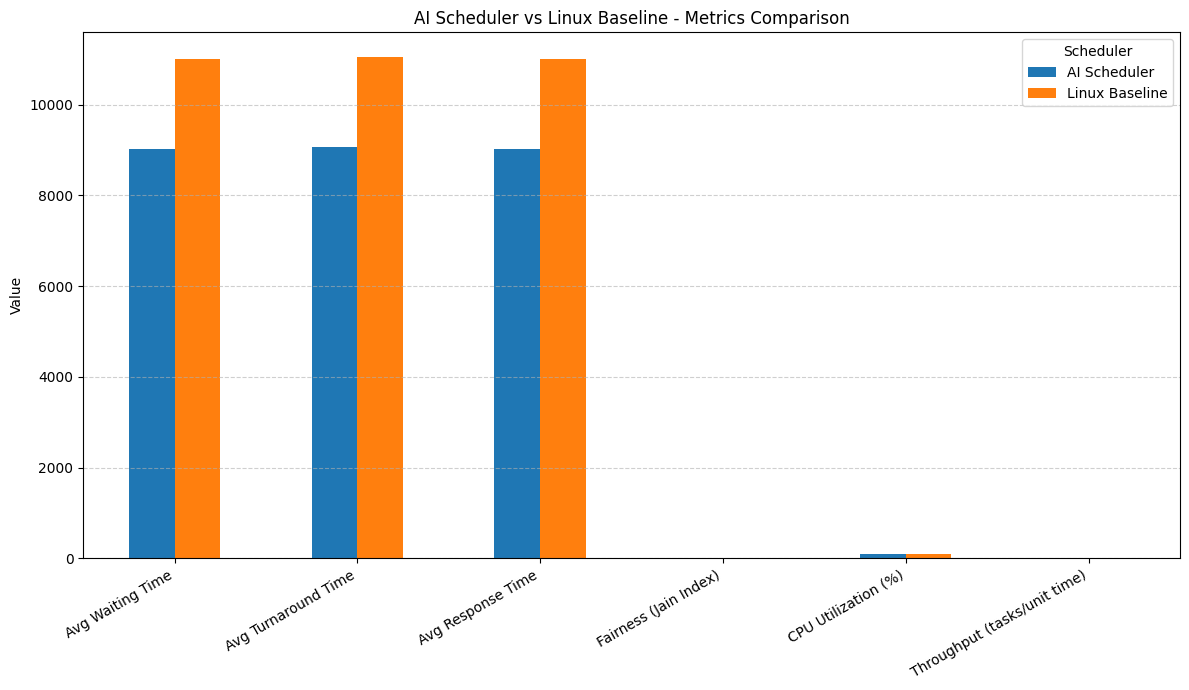

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load AI and Linux data
ai_logs = pd.read_csv("ai_scheduler_logs.csv")
ai_tasks = pd.read_csv("ai_scheduler_task_metrics.csv")
linux_logs = pd.read_csv("linux_baseline_logs.csv")
linux_tasks = pd.read_csv("linux_baseline_task_metrics.csv")

# ---- AI Metrics ----
def compute_metrics_ai(tasks: pd.DataFrame, logs: pd.DataFrame):
    metrics = {}
    # From per-task metrics
    metrics["Avg Waiting Time"] = tasks["waiting"].mean()
    metrics["Avg Turnaround Time"] = tasks["turnaround"].mean()
    metrics["Avg Response Time"] = tasks["response"].mean()
    metrics["Fairness (Jain Index)"] = (tasks["execution_time"].sum()**2) / (
        len(tasks) * (np.sum(tasks["execution_time"]**2) + 1e-9)
    )
    # From logs
    run_events = logs[logs["event"] == "RUN"]
    total_run_time = len(run_events)
    total_time = logs["time"].max() - logs["time"].min() + 1
    metrics["CPU Utilization (%)"] = 100 * total_run_time / (total_time * logs["core"].nunique())
    metrics["Throughput (tasks/unit time)"] = len(tasks) / total_time
    return metrics

# ---- Linux Metrics ----
def compute_metrics_linux(tasks: pd.DataFrame, logs: pd.DataFrame):
    metrics = {}
    metrics["Avg Waiting Time"] = tasks["waiting"].mean()
    metrics["Avg Turnaround Time"] = tasks["turnaround"].mean()
    metrics["Avg Response Time"] = tasks["response"].mean()
    metrics["Fairness (Jain Index)"] = (tasks["execution_time"].sum()**2) / (
        len(tasks) * (np.sum(tasks["execution_time"]**2) + 1e-9)
    )
    run_events = logs[logs["event"] == "RUN"]
    total_run_time = len(run_events)
    total_time = logs["time"].max() - logs["time"].min() + 1
    metrics["CPU Utilization (%)"] = 100 * total_run_time / (total_time * logs["core"].nunique())
    metrics["Throughput (tasks/unit time)"] = len(tasks) / total_time
    return metrics

# Compute both
ai_metrics = compute_metrics_ai(ai_tasks, ai_logs)
linux_metrics = compute_metrics_linux(linux_tasks, linux_logs)

# Compare side by side
comparison_df = pd.DataFrame([ai_metrics, linux_metrics], index=["AI Scheduler", "Linux Baseline"])
print("\n📊 Full Metrics Comparison:\n", comparison_df)

# Plot numeric metrics
comparison_df.T.plot(kind="bar", figsize=(12,7))
plt.title("AI Scheduler vs Linux Baseline - Metrics Comparison")
plt.ylabel("Value")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Scheduler")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
